In [165]:
import pandas as pd

data = pd.read_csv('../../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUT/merged_segements_10T.csv')
data_gps = pd.read_csv('../../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUT/merged_gps_data_10T.csv')

grouped_data = data_gps['segment_id'].value_counts()

filtered_segment_ids = grouped_data[(grouped_data > 30) & (grouped_data < 50)].index.tolist()

filtered_data = data[data['segment_id'].isin(filtered_segment_ids)]
data = filtered_data


In [166]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def elbow_method(result,clustering_features):
  # eg :- clustering_features = ['speed_mean', 'speed_variance']
  X = result[clustering_features]

  # Standardize the data (important for K-Means)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Initialize lists to store inertia values for different k
  inertia_values = []

  # Determine a range of k values to test (e.g., from 1 to 10 clusters)
  k_values = range(1, 11)

  # Calculate inertia for each k value
  for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0,n_init=10)
      kmeans.fit(X_scaled)
      inertia_values.append(kmeans.inertia_)

  # Plot the elbow graph
  plt.plot(k_values, inertia_values, marker='o', linestyle='-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia')
  plt.title('Elbow Method for Optimal k')
  plt.grid(True)
  plt.show()

In [167]:
def bim_mean_smoothing(df,columns,data_per_bin):

    for index in range(len(columns)):
        data = df[columns[index]]
        # Specify the number of bins
        num_bins = round(len(data)/data_per_bin)
        # 5000

        # Dynamically calculate bin edges based on quantiles
        bin_edges = pd.qcut(data, q=num_bins, retbins=True, duplicates='drop')[1]
        bin_edges[0] = bin_edges[0]-1

        bin_labels = [f'Bin {i}' for i in range(1, len(bin_edges))]

        # Use cut to bin the data
        bin_name = "bin_name_"+columns[index]
        df[bin_name] = pd.cut(data, bins=bin_edges, labels=bin_labels)

        # Calculate bin means
        bin_means = df.groupby(bin_name)[columns[index]].mean()

        # Replace values with bin means
        new_col = 'bin_'+columns[index]
        df[new_col] = df[bin_name].map(bin_means)
        df = df.drop(bin_name, axis=1)

    return df

In [168]:
columns_used = [ 'elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'stop_count', 'average_speed', 'max_speed', 'speed_variation']
data = data.dropna(subset=columns_used)
# elbow_method(data,['elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'stop_count', 'average_speed', 'max_speed', 'speed_variation'])

K means

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data_kmean = data.copy()
# Select the features for clustering
X = data_kmean[['ele_X_speed_acc_p', 'std_acc_dacc']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
data_kmean['cluster'] = kmeans.fit_predict(X_scaled)

# Add 'deviceid' back to the clustered data
# clustered_data = pd.merge(df_all, result[['deviceid', 'cluster']], on='deviceid')

# Create a scatter plot with annotations
groups = data_kmean['cluster'].unique()

for group in groups:
    group_data = data_kmean[data_kmean['cluster'] == group]
    plt.scatter(group_data['ele_X_speed_acc_p'], group_data['std_acc_dacc'], label=group)

plt.xlabel('ele_X_speed_acc_p')
plt.ylabel('std_acc_dacc')
plt.legend(title='Groups')

# Show the plot
plt.show()

Scaler + PCA

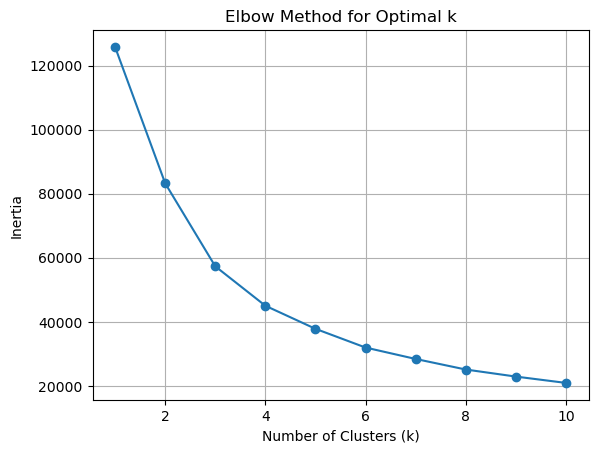

In [169]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data = data.dropna(subset=columns_used)
pca_data = data.copy()
# Select the features for clustering
X = data[columns_used]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(data=X_scaled, columns=columns_used)
# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)

# principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3', 'PC4','PC5'])
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

pca_data['PC1'] = principal_df['PC1']
pca_data['PC2'] = principal_df['PC2']

elbow_method(principal_df,['PC1', 'PC2'])
# X_scaled_df

K means After PCA

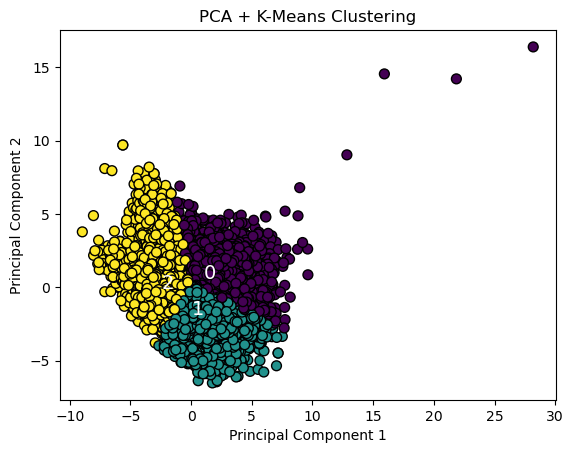

In [170]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

principal_df_copy = principal_df.copy()
principal_components_copy = principal_components.copy()
pca_data_copy = pca_data.copy()

# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
pca_data_copy['cluster'] = kmeans.fit_predict(principal_components_copy)

pca_data_copy=pca_data_copy.reset_index(drop=True)
principal_df_copy=principal_df_copy.reset_index(drop=True)

# Fit K-Means on the principal components
principal_df_copy['cluster'] = pca_data_copy['cluster']

centers = kmeans.cluster_centers_
# Add cluster labels to each point
for i in range(0,len(centers)) :
    plt.text(centers[i, 0], centers[i, 1], str(i), fontsize=14, ha='center', va='center', c='white')

# Plot the clusters in the reduced space
plt.scatter(principal_df_copy['PC1'], principal_df_copy['PC2'], c=principal_df_copy['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



# Calculate Silhouette Score
# silhouette_avg = silhouette_score(principal_components_copy, pca_data_copy['cluster'])

# print(f"For k={3}, Silhouette Score: {silhouette_avg}")

# # Calculate Davies-Bouldin Index
# db_index = davies_bouldin_score(principal_components_copy, pca_data_copy['cluster'])

# print(f"For k={3}, Davies-Bouldin Index: {db_index}")



# pca_data_copy.to_csv('k_PCA-2_4 rows.csv', index=False)
# columns_used.append("cluster")
# pca_data_copy[columns_used+["segment_id","cluster"]][pca_data_copy["cluster"]==0].head(5)


Variance or Standard Deviation

In [171]:
import numpy as np

feature_names = columns_used
n_clusters = np.max(pca_data_copy['cluster']) + 1

def calculate_feature_statistics(data, labels, statistic="std"):
    num_clusters = np.max(labels) + 1
    feature_statistics_per_cluster = []

    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_data = data.iloc[cluster_indices]

        # Calculate variance or standard deviation for each feature
        if statistic == "std":
            feature_statistics = np.std(cluster_data, axis=0)
        elif statistic == "var":
            feature_statistics = np.var(cluster_data, axis=0)
        else:
            raise ValueError("Invalid statistic. Use 'std' or 'var'.")

        feature_statistics_per_cluster.append(feature_statistics)

    return feature_statistics_per_cluster

# Calculate standard deviation for each feature within clusters
std_per_feature = calculate_feature_statistics(X_scaled_df[columns_used], pca_data_copy['cluster'], statistic="std")

# Calculate variance for each feature within clusters
# var_per_feature = calculate_feature_statistics(X, labels, statistic="var")

# Create a DataFrame to display the results

cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]
std_df = pd.DataFrame(np.array(std_per_feature).T, columns=cluster_names, index=feature_names)
# var_df = pd.DataFrame(np.array(var_per_feature).T, columns=cluster_names, index=feature_names)

std_df.to_csv('kmeans_clusters_feature_std.csv', index=True)

# Print the results
print("Standard Deviation:")
std_df


Standard Deviation:


,Cluster 1,Cluster 2,Cluster 3
elevation_p,0.931525,0.749857,1.101802
elevation_n,0.979855,0.852203,1.077170
ele_X_speed_acc_p,1.007642,1.109874,0.849916
ele_X_speed_acc_n,1.019708,1.029326,0.759117
average_acceleration,1.052690,0.715565,0.709152
average_deacceleration,0.834198,0.534968,0.653252
std_acc_dacc,0.767453,0.563966,0.700000
stop_count,0.655213,0.668509,1.038052
average_speed,0.658307,0.739337,0.732006
max_speed,0.775066,0.788663,0.618337


Data Smoothing (Binning Mean)

In [ ]:
smoothed_data = bim_mean_smoothing(pca_data_copy,columns_used,6000)
smoothed_data.head()

In [ ]:
elbow_method(smoothed_data,["PC1","PC2"])

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


# data = data.dropna(subset=['elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'stop_count', 'average_speed', 'max_speed', 'speed_variation'])

smoothed_data_copy = smoothed_data.copy()
# Select the features for clustering
X = smoothed_data_copy[['bin_ele_X_speed_acc_p', 'bin_ele_X_speed_acc_n','bin_std_acc_dacc', 'bin_speed_variation','bin_average_speed']]


# 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'speed_variation','average_speed', 'max_speed'

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Set the number of components as needed
smoothed_principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
smoothed_principal_df = pd.DataFrame(data=smoothed_principal_components, columns=['PC1', 'PC2'])

# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
smoothed_data_copy['cluster'] = kmeans.fit_predict(smoothed_principal_components)

smoothed_data_copy=smoothed_data_copy.reset_index(drop=True)
smoothed_principal_df=smoothed_principal_df.reset_index(drop=True)
# Fit K-Means on the principal components
smoothed_principal_df['cluster'] = smoothed_data_copy['cluster']


smoothed_data_copy['PC1'] = smoothed_principal_df['PC1']
smoothed_data_copy['PC2'] = smoothed_principal_df['PC2']

# # Calculate Silhouette Score
# silhouette_avg = silhouette_score(smoothed_principal_components, smoothed_data_copy['cluster'])

# print(f"For k={3}, Silhouette Score: {silhouette_avg}")

# # Calculate Davies-Bouldin Index
# db_index = davies_bouldin_score(smoothed_principal_components, smoothed_data_copy['cluster'])

# print(f"For k={3}, Davies-Bouldin Index: {db_index}")

# Plot the clusters in the reduced space
plt.scatter(smoothed_principal_df['PC1'], smoothed_principal_df['PC2'], c=smoothed_principal_df['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# data.to_csv('kmeans_clusters_smooth_PCA-2.csv', index=False)



For Loop for Binning

In [ ]:
import os
data_per_bin_arr=[]
silhouette_avg_arr=[]
db_index_arr =[]


for data_per_bin in range(1000,20000,2000):

    smoothed_data = bim_mean_smoothing(pca_data_copy,columns_used,data_per_bin)
    smoothed_data_copy = smoothed_data.copy()
    # Select the features for clustering
    X = smoothed_data_copy[['bin_ele_X_speed_acc_p', 'bin_ele_X_speed_acc_n','bin_std_acc_dacc', 'bin_speed_variation','bin_average_speed']]


    # 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'speed_variation','average_speed', 'max_speed'

    # Standardize the data (important for K-Means)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)  # Set the number of components as needed
    smoothed_principal_components = pca.fit_transform(X_scaled)

    # Create a DataFrame with the principal components
    smoothed_principal_df = pd.DataFrame(data=smoothed_principal_components, columns=['PC1', 'PC2'])

    # Perform K-Means clustering
    k = 3  # You can choose the number of clusters (k) as needed
    kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
    smoothed_data_copy['cluster'] = kmeans.fit_predict(smoothed_principal_components)

    smoothed_data_copy=smoothed_data_copy.reset_index(drop=True)
    smoothed_principal_df=smoothed_principal_df.reset_index(drop=True)
    # Fit K-Means on the principal components
    smoothed_principal_df['cluster'] = smoothed_data_copy['cluster']


    smoothed_data_copy['PC1'] = smoothed_principal_df['PC1']
    smoothed_data_copy['PC2'] = smoothed_principal_df['PC2']

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(smoothed_principal_components, smoothed_data_copy['cluster'])

    print(f"For k={3}, Silhouette Score: {silhouette_avg}")

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(smoothed_principal_components, smoothed_data_copy['cluster'])

    print(f"For k={3}, Davies-Bouldin Index: {db_index}")

    plt.figure()

    plt.text(2.5, 12, 'data_per_bin: '+str(data_per_bin), fontsize=10, ha='center', va='center')
    plt.text(2.5, 11.5, 'For k=3, Silhouette Score: '+str(silhouette_avg), fontsize=10, ha='center', va='center')
    plt.text(2.5, 11, 'For k=3, Davies-Bouldin Index: '+str(db_index), fontsize=10, ha='center', va='center')

    # Plot the clusters in the reduced space
    plt.scatter(smoothed_principal_df['PC1'], smoothed_principal_df['PC2'], c=smoothed_principal_df['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
    plt.title('')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.savefig(os.path.join("gimhan_images", str(data_per_bin)+'.png'))

    data_per_bin_arr.append(data_per_bin)
    silhouette_avg_arr.append(silhouette_avg)
    db_index_arr.append(db_index)

data = {'data_per_bin': data_per_bin_arr, 'silhouette_avg': silhouette_avg_arr, 'db_index': db_index_arr}
df_bin = pd.DataFrame(data)
df_bin.to_csv('df_bin_new.csv', index=False)

In [ ]:
smoothed_data.to_csv('kmeans_bin_clusters.csv', index=False)

In [ ]:
df_bin_gap_2000 = pd.read_csv('df_bin_new.csv')
df_bin_gap_2000.head()

In [ ]:
plt.figure()
plt.plot(df_bin_gap_2000["data_per_bin"], df_bin_gap_2000["silhouette_avg"], marker='o', linestyle='-')
plt.plot(df_bin_gap_2000["data_per_bin"], df_bin_gap_2000["db_index"], marker='x', linestyle='-')
plt.xlabel('data_per_bin')
plt.ylabel('Score')
# plt.title('silhouette_avg')
plt.grid(True)
plt.show()